In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_map import SortedConv2DWithMap

import datetime


c:\Users\Liam_gaming\anaconda3\envs\sys809\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y, map = SortedConv2DWithMap(filters=10 ,activation=ReLU(), padding='SAME')(input_net)
model = Model(inputs = input_net, outputs = y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d_with_map (Sor  ((None, 32, 32, 10),     102       
 tedConv2DWithMap)            (None, 32, 32))                    
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


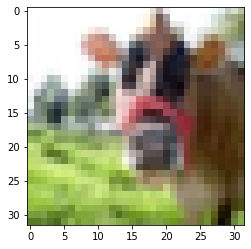

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [5]:
model = Model(inputs = input_net, outputs = y)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 1e-6,
    m_mul=0.999,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs_shift_experiments/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 200
epochs = 100
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

In [6]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


(32, 32, 3)
(1, 32, 32, 10)
(1, 32, 32, 1)
tf.Tensor([4], shape=(1,), dtype=int64)
(1, 1024, 10)


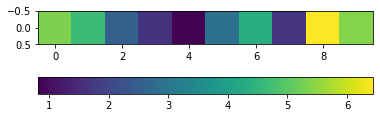

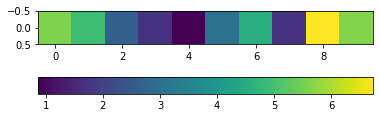

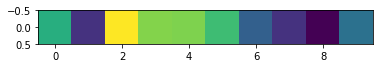

In [68]:
from tensorflow.compat.v1 import extract_image_patches

def extract_patches(x):
    
    patches =  extract_image_patches(x, [1, 4,4, 1],  [1, 4, 4, 1],  rates = [1,1,1,1] , padding = 'SAME')
    return tf.reshape(patches, [-1, 4, 4, x.shape[-1]])
# Thanks to https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches_inverse( x, y):
    _x = tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return tf.gradients(_y, _x, grad_ys=y)[0] / grad


get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = x_test[n]
print(X.shape)



out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])
print(out.shape)

plt.figure(1)  
im = plt.imshow(out[:,0,4])   
plt.colorbar(im, ticks=range(8), orientation="horizontal")

max_channels  = tf.cast(map, tf.float32)
averages = tf.nn.avg_pool2d((tf.expand_dims(max_channels, axis=-1)), ksize=[4, 4] , strides=[4, 4], padding='VALID')
map = tf.repeat(averages, repeats = 4, axis=1)
map = tf.repeat(map, repeats = 4, axis=2)
map  = tf.cast(map, tf.int64)

#out = extract_patches_inverse(r, out)
print(map.shape)

plt.figure(2)  
im = plt.imshow(out[:,0, 13]) 
plt.colorbar(im, ticks=range(8), orientation="horizontal")
print(map[0,0,13])

out = tf.reshape(out, [-1, out.shape[1]*out.shape[2], out.shape[3] ])
map = tf.reshape(map, [-1, map.shape[1]*map.shape[2]])
print(out.shape)
# Thanks lampuiho --> https://github.com/tensorflow/tensorflow/issues/43655
shifted = tf.map_fn(lambda t: tf.map_fn(lambda i : tf.roll(t[0][i], t[1][i], -1), tf.range(1024), fn_output_signature=tf.float32), (out, map), fn_output_signature=tf.float32)
shifted = tf.reshape(shifted, [-1, 32, 32, 10])

plt.figure(3)  
plt.imshow(shifted[:, 0,13])   



In [ ]:
model.layers[4].trainable_variables[3].name

IndexError: list index out of range

In [ ]:
model.layers[1].gain

: 

In [ ]:
model.layers[5].scale_a

: 

: 